<div style="font-size:22pt; line-height:25pt; font-weight:bold; text-align:center;">Natural Language Generation</div>

In this exercice, we will try out the approach of Natural Language Generation, using a Seq2Seq (sequence to sequence) architecture.

This notebook is a variant of the 3rd notebook on Natural Language Generation, using pyTorch instead of Keras/TF.
It is an adaptation of the excellent pyTorch tutorial on Seq2Seq approaches.

Natural Language Generation has often used approaches close to "fill-in-the-blanks" templates. 
Seq2Seq Encoder-Decoder architectures make the issue of Natural Language Generation different, especially in the case of language translation.

The approach is the following :
1. A LSTM network encodes the input sequence into state vectors, with a predefined dimensionality
2. A decoder LSTM predicts the next token of a target sequence based on the beginning o the sequence. The initial state is given by the encoder.

The approach used here to train a system that predicts the next token based on the beginning of the sequence is called Teacher Forcing

# 1. Parameters of the experiment

In this example, we will train a system that translates basic english sentences into french. The data used for this example is a list of French sentences and their translation into english.

# 1. Teacher forcing

## 1.a Example

Say we work with the following sequence :

```
Rien ne sert de courir il faut partir à point
```

We want to train a model that predicts the following word of the sequence based on the start of it. First, in order for the first word of the sequence and the end of it to be predicted, we need to add beginning and end tokens to the sequence. We decide to use \t as the beginning token, and \n as the end one :

```
\t Rien ne sert de courir il faut partir à point \n
```

When training the system, we start by inputing the "\t" beginning token:

```
input: 
\t
prediction:
sert
```

The untrained model generated "sert" where we expected "Mary". There are now two options to continue :

### Without forcing :

We add the previous output, "sert", to the input sequence, and continue generating :

```
input: 
\t sert
```

With this approach, the error will propagate and make the model much slower to learn. 

### With teacher forcing

After computing error, we discard the output "sert", and replace it with the word that was actually expected ("Rien"). This is called *teacher forcing* :

```
input: 
\t Rien
```

Using his technique provides much faster training of the model. However, please note that it can also be a source of instability on previously unseen data.

# 2. Importing data


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

hidden_size = 256  # Latent dimensionality of the encoding space.

# Path to the data
data_path = 'datasets/enfratexts.txt'

#setting up device for use with pyTorch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device used is ",device)

device used is  cpu


## 2.1 Utils to import and preprocess data

We vectorize the data using words as features. 

This means that we will first define a vocabulary containing all the words in our corpus (simalr to what we did in notebook 1 for BOW and TFIDF calculation). The sequences will then be vectorized as a sequence of ints, corresponding to the id a given word in the dictionnary.

This section defines a set of utilities to import data :
- A class defining the characteristics of the languages imported (french and english), including the size of the vocabulary and the dictionnary mapping words to indexes.
- Methods to import data, including a simple preprocessing that lowercases all the characters and removes special characters, in order to control the size of our dictionnay (see notebook 1). 
- Methods to select data from our dataset, useful for running iterations of our network.

Please note that contrary to what we did for classification, the preprocessing does not include Lemmatization or Stemming. This is logical, considering we need to keep data readable by a human. 
And also don't forget that we are using two special characters "1" for start of sequence and "0" for end of sequence.

In [2]:
# Start and end sequence tokens
Start_sentence_token = 1
End_sentence_token = 0


#Class defining a language.
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}#Contains the index of each word in the dictionnary
        self.word2count = {}#Contains the count of each word
        self.index2word = {1: "SOS", 0: "EOS"} #Reverse lookup table for words (useful for decoding sentences back to a readable form)
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
            
            
## UTILS
import re, unicodedata

# Convert to ASCII (because of french sentences)
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Trim, lowercase sentences and remove special chracters except punctuation
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

# Filter data to keep only some relevant pairs. In particular, to ensure that the system trains fast enough,
# we define a max length for sequences and keep only sentences sentences that start the same.
max_length = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < max_length and len(p[1].split(' ')) < max_length and p[0].startswith(eng_prefixes)
def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


# Reading, Normalizing data
def readLangs(lang1, lang2):
    print("Reading lines...")
    # Read the file and split into lines
    lines = open(data_path, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    # Create language objects
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)

    return input_lang, output_lang, pairs



# Full pipeline for importing data :
# Reads the files, and cleans data
# Filters pairs of english/french sentences to keep only those that are short enough and start the same
def prepareData(lang1, lang2):
    input_lang, output_lang, pairs = readLangs(lang1, lang2)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Filtered to %s sentence pairs" % len(pairs))
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Dictionnary size:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

## 2.2 Import and prepare data

In [3]:
import random

input_lang, output_lang, pairs = prepareData('english', 'francais')

Reading lines...
Read 170651 sentence pairs
Filtered to 12761 sentence pairs
Dictionnary size:
english 3054
francais 4740


# 3. Vectorizing the data



In the previous section we defined a dictionnary to vectorize data in a BOW fashion. 

Vectorizing data for use by our Neural Network is performed through the folowing steps :
- Step 1 : using the dictionnary, the sequence of words is turned into a sequence of indexes
- Step 2 : we append the End of Sentence token. Then, the sequence of indexes is turned into a tensor for use by pyTorch. 

In [4]:
# STEP 1
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

# STEP 2
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(End_sentence_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

# Performing the two steps of vectorization on a pair of english/french sequences
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

# 3.0. Defining the Encoder-Decoder Architecture

## 3.1. Encoder

Encoding is performed via a LSTM, whose state we will store to condition the decoding. 
Inputs are first embedded into fixed dimensional space, and then encoded by the lstm. We also keep the hidden states of the lstm, as we need to feed them to the encoder for the next iteration.


In [5]:
class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Encoder, self).__init__()
        
        self.hidden_size = hidden_size
        #Embedding Layer
        self.embedding = nn.Embedding(input_size, hidden_size)
        #LSTM Layer
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        
        
    def forward(self, input, hidden):
        
        #Embedding the input
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        # We feed the embedded vector as well as the hidden states passed as argument into the lstm
        output, hidden = self.lstm(output, hidden)
        return output, hidden

## 3.2. Decoder

The decoder is meant to predict the next token of the target sentence, knowing the current token and the context vectors given by the encoder (hidden vectors).
The context vectors ancode the input sequence that was given, and will condition all the prediction of the decoder.

In [6]:
class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(Decoder, self).__init__()
        
        self.hidden_size = hidden_size
        #Embedding Laeyr
        self.embedding = nn.Embedding(output_size, hidden_size)
        #LSTM Layer
        self.lstm = nn.LSTM(hidden_size, hidden_size)
        #Linear layer mapping to the output size
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        
        #Embedding the input and applying relu
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        
        # We feed the embedded vector as well as the context vector passed as argument into the lstm
        output, hidden = self.lstm(output, hidden)
        # Softmax layer (probabilities of each token)
        output = self.softmax(self.out(output[0]))
        
        return output, hidden




# 4. Training the model

First, we write a function that defines one step of training the model :

In [7]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):
    
    #initialize hidden and cell state of the encoder lstm randomly
    encoder_hidden = torch.randn(1, 1, hidden_size)
    encoder_cell = torch.randn(1, 1, hidden_size)

    #zero out the gradients
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    
    #Get length of input and target sequences
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    loss = 0
    
    ## ENCODER
    #initialize the output of the encoder to zero
    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    #We pass each input token to the encoder. At each step, we retrive the output and the hidden/cell states,
    #forming the context vector. The context vector is fed back to the encoder for the next step.
    for ei in range(input_length):
        encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei], (encoder_hidden,encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    ## DECODER
    #For the decoder, the input is initialized with a Start of Sequence token
    decoder_input = torch.tensor([[Start_sentence_token]], device=device)

    #The decoder states are initialized by passing the context vector from the encoder
    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    #We pass each target token to the decoder. We keep the hidden and cell states, that we will feed back to the
    #decoder for the next step. However, the outputs are discarded, and the next input of the decoder is the target
    #output (see teacher forcing above)
    for di in range(target_length):
        decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    #Backward prop
    loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    #Return loss
    return loss.item() / target_length

## 4.1 Plotting loss

We have setup the trainign function to return the current loss of the model. 
The function below displays the learning curve

In [8]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)


## 4.2. Running multiple iterations

In [9]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    
    plot_losses = [] #Will hold all losses for plotting
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    #Setup optimizers
    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    
    #Prepare n_iter training data to run n-iter steps
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    
    criterion = nn.NLLLoss()

    
    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        
        # Retrieve the next tensors for input and target
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        #Run one step of training
        loss = train(input_tensor, target_tensor, encoder,decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        #Every few steps, we print the current status of training. We also store the loss for plotting
        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(iteration %d %d%%) loss = %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #Plot learning curve at the end
    showPlot(plot_losses)


## 4.3. Application

(iteration 1000 1%) loss = 4.3580
(iteration 2000 2%) loss = 3.5869
(iteration 3000 4%) loss = 3.3769
(iteration 4000 5%) loss = 3.1932
(iteration 5000 6%) loss = 3.0266
(iteration 6000 8%) loss = 2.9167
(iteration 7000 9%) loss = 2.7993
(iteration 8000 10%) loss = 2.7012
(iteration 9000 12%) loss = 2.6363
(iteration 10000 13%) loss = 2.5246
(iteration 11000 14%) loss = 2.4395
(iteration 12000 16%) loss = 2.4261
(iteration 13000 17%) loss = 2.3700
(iteration 14000 18%) loss = 2.3195
(iteration 15000 20%) loss = 2.2809
(iteration 16000 21%) loss = 2.1337
(iteration 17000 22%) loss = 2.1534
(iteration 18000 24%) loss = 2.0646
(iteration 19000 25%) loss = 2.0489
(iteration 20000 26%) loss = 2.0235
(iteration 21000 28%) loss = 1.9572
(iteration 22000 29%) loss = 1.9466
(iteration 23000 30%) loss = 1.9160
(iteration 24000 32%) loss = 1.8492
(iteration 25000 33%) loss = 1.8286
(iteration 26000 34%) loss = 1.7288
(iteration 27000 36%) loss = 1.6758
(iteration 28000 37%) loss = 1.7280
(iterati

<Figure size 432x288 with 0 Axes>

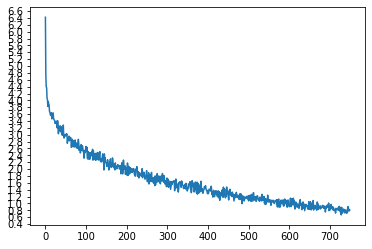

In [10]:
encoder = Encoder(input_lang.n_words, hidden_size).to(device)
decoder = Decoder(hidden_size, output_lang.n_words).to(device)

trainIters(encoder, decoder, 75000, print_every=1000,plot_every=100)

## 4.4. Inference

For inference, the only difference with training is that we will continue to feed back the network's predictions to itself at each step, and stop only when we predict an end of sentence token.

In [12]:
def inference(encoder, decoder, sentence, max_length=max_length):
    
    with torch.no_grad(): #Freeze gradient
        
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        
        #Initialize the encoder hidden states
        encoder_hidden = torch.randn(1, 1, hidden_size)
        encoder_cell = torch.randn(1, 1, hidden_size)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        ##ENCODER
        for ei in range(input_length):
            encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden,encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        #Initialize decoder input with a start of sentence token
        decoder_input = torch.tensor([[Start_sentence_token]], device=device) 

        #Feed the encoder context vectors to the decoder
        decoder_hidden = encoder_hidden
        decoder_cell=encoder_cell

        decoded_words = [] #Will hold the decoded sequence (translation)

        for di in range(max_length):
            decoder_output, (decoder_hidden,decoder_cell) = decoder(decoder_input, (decoder_hidden,decoder_cell))
            
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == End_sentence_token:
                decoded_words.append('<EOS>')
                break #Stop if we predict an end of sentence token
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach() #Use the previously predicted token as the input for the next step

        return decoded_words

We define a util function that will evaluate 10 random sentences from the train set and try to translate them

In [13]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words = inference(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [14]:
evaluateRandomly(encoder, decoder)

> you re a good chess player .
= vous etes un bon joueur d echecs .
< tu es un bon joueur d echecs . <EOS>

> i m not a good liar .
= je ne suis pas un bon menteur .
< je ne suis pas une bonne menteuse . <EOS>

> he s not sure he s ready .
= il n est pas sur d etre pret .
< il n est pas sur d etre pret . <EOS>

> we re astonished .
= nous sommes stupefaits .
< nous sommes en train d etre de nous . <EOS>

> they re all here .
= ils sont tous ici .
< ils sont toutes la . <EOS>

> he is ashamed to ask questions .
= il a honte de poser des questions .
< j ai honte de dormir a l anglais . <EOS>

> i m from the west coast .
= je suis de la cote ouest .
< je suis de la cote cote . <EOS>

> you re really hard to understand .
= tu es vraiment difficile a comprendre .
< vous etes vraiment difficile a comprendre . <EOS>

> i am anxious about his health .
= je suis inquiet pour sa sante .
< je suis inquiet pour sa voiture . <EOS>

> i m sure we can work this out .
= je suis sur que nous pouvons ar

After only a few training steps, we observe that translations are often all identical. It would take more several thousands of training iterations (probably about 100 000) to reach a satisfying result with this system. There are two main reasons that can explain this problem :

- First, the **use of teacher forcing**. Because we systematically correct the predictions of the network during training, the system has a tendency to learn to predict sentences that are grammatically correct, but would fail to learn the actual meaning. As an exercise, we could try to modfy the train function to not include teacher forcing. The flexibility of PyTorch also allows us to use teacher forcing sometimes, but not always.
- Then, the **architecture of the network**. Here, because the context vectors fed into the decoder are the same for a given input sentence, this means that the encoder has the responsibility to learn representations for the input sequence ***in its entirety***. For longer sentences, this isquite unefficient. In the rest of this notebook, we will introduce the notion of attention, as a response to this issue.

# 5. Using Attention

A variant of the previous Seq2Seq system involves a mechanism mimicking **attention**. With this mechanism, instead of conditionning the prediction using the raw context vector, we will apply attention weights In practice, this means that the system will learn to "use" some parts of the encoder output more than others when predicting a sequence.

## 5.1. Implementing a decoder with attention

In this paradigm, encoding is performed in the same way as previously. 

In the previous system, the decoder predicted the next token of the target sequence based on the known one. This prediction was conditioned by the encoded context vectors.
The difference here is that instead of directly predicting the next token from the input, the decoder will first predict where to focus its attention on the encoded sequence, and will then use this attended vector as well as the input topredict what the next token is.

Let's write the new version of our decoder :

In [37]:
class AttnDecoder(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=max_length):
        super(AttnDecoder, self).__init__()
        
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p #dropout probability
        self.max_length = max_length

        #Embedding layers for the decoder input
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        
        #First, the input (target sequence) is embedded. Some weights are randomly zeroed out to facilitate
        #learning with the attention mechanism
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)
        
        #Attention is computed by combining the context vectors and the embedded input (french sequence)
        attn_weights = F.softmax(self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)
        #Attention is applied on the encoded original sentence (in english)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),encoder_outputs.unsqueeze(0))

        #We retrieve the embedded input and the context vector (with attention applied), and combine the two tensors
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        
        #The attended part of the input is fed into the lstm, conditioned by the hidden and cell states
        output, hidden = self.lstm(output, hidden)
        #Retrieve token probabilities
        output = F.log_softmax(self.out(output[0]), dim=1)
        
        #In addition to the output and hidden states that are necessary for iterating, we return the attention
        #weights, that will provide some form of explainability
        return output, hidden, attn_weights


Because the input and output of the forward pass of this decoder is not the same as before (we added the attention weights and encoder output), we need to adapt the train, trainIter and inference functions :

In [16]:
def train_with_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=max_length):

    encoder_hidden = torch.randn(1, 1, hidden_size)
    encoder_cell = torch.randn(1, 1, hidden_size)

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei], (encoder_hidden,encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[Start_sentence_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell
    
    # THE ONLY CHANGES OCCURS HERE, AS WE NEED TO ADD encoder_output AS AN INPUT AND attention AS AN OUTPUT
    for di in range(target_length):
        decoder_output, (decoder_hidden,decoder_cell), decoder_attention  = decoder(decoder_input, (decoder_hidden,decoder_cell), encoder_outputs)
        loss += criterion(decoder_output, target_tensor[di])
        decoder_input = target_tensor[di]  # Teacher forcing

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

#Iterations of training
def trainIters_with_attention(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0 

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs)) for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]
        
        #THE ONLY CHANGE HAPPENS HERE, AS WE NEED TO CALL THE TRAIN_WITH_ATTENTION FUNCTION
        loss = train_with_attention(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('(iteration %d %d%%) loss = %.4f' % (iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)
  
#evaluation function
def inference_with_attention(encoder, decoder, sentence, max_length=max_length):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = torch.randn(1, 1, hidden_size)
        encoder_cell = torch.randn(1, 1, hidden_size)

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden,encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden,encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[Start_sentence_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        # ONLY CHANGE IS HERE
        for di in range(max_length):
            decoder_output, (decoder_hidden,decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden,decoder_cell), encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == End_sentence_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

#evaluate several sentences picked randomly    
def evaluateRandomly_with_attention(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = inference_with_attention(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')


Let's train and test this system !

(iteration 100 10%) loss = 7.0271
(iteration 200 20%) loss = 5.0872
(iteration 300 30%) loss = 4.4355
(iteration 400 40%) loss = 4.1733
(iteration 500 50%) loss = 3.9742
(iteration 600 60%) loss = 4.0786
(iteration 700 70%) loss = 4.0249
(iteration 800 80%) loss = 3.9406
(iteration 900 90%) loss = 3.7225
(iteration 1000 100%) loss = 3.6683


<Figure size 432x288 with 0 Axes>

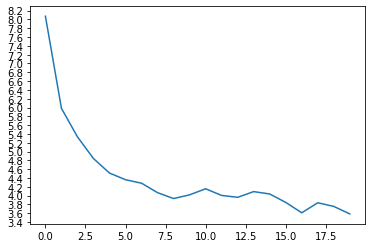

In [17]:
encoder_for_attn = Encoder(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttentionDecoder(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)


trainIters_with_attention(encoder_for_attn, attn_decoder, 1000, print_every=100,plot_every=50)

In [52]:
evaluateRandomly_with_attention(encoder_for_attn, attn_decoder)

> i m worried about you .
= je m inquiete pour toi .
< je suis inquiet a vous . <EOS>

> you re right on time .
= vous etes juste a l heure .
< tu es a l heure . <EOS>

> i m feeling kind of tired .
= je me sens un peu fatigue .
< je me sens plutot fatigue . <EOS>

> you re the same age as my girlfriend .
= tu as le meme age que ma copine .
< tu as le meme age que ma copine . <EOS>

> i m not making any plans .
= je ne fais pas le moindre projet .
< je ne fais pas de l argent . <EOS>

> she s not admitting her mistake .
= elle n admet pas son erreur .
< elle n admet pas son erreur . <EOS>

> you re sleepy so go to bed .
= vous avez sommeil donc allez vous coucher .
< vous etes tellement difficile a te aller . <EOS>

> i m right here .
= je suis juste ici .
< je suis juste la . <EOS>

> we re all alone .
= nous sommes tous seuls .
< nous sommes tous seules . <EOS>

> you re very brave .
= vous etes tres courageux .
< vous etes tres courageux . <EOS>



## 5.2. Visualize attention

One of the advantages of using attention is that it provides explainability of the output. As we have the ability to see what part of the sequence was attended to when predicting a given output token, it provides an explanation of correspondences between target and input tokens.

In this section, we will write a function to visualize attention weights

In [45]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = inference_with_attention(
        encoder_for_attn, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)



input = i am not making any plans .
output = je ne fais pas de l argent . <EOS>


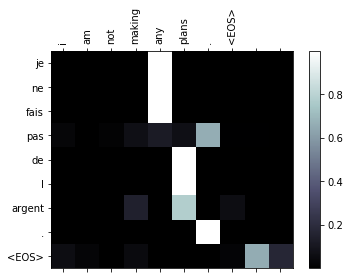

In [53]:
evaluateAndShowAttention("i am not making any plans .")

### Util : load or save a previous model

In [ ]:
torch.save(attn_decoder,'att_decoder')
torch.save(attn_encoder,'att_encoder')

In [40]:
attn_decoder = torch.load('attn_decoder')
encoder_for_attn=torch.load('attn_encoder')